# Trabalho Final - Disciplina RNA e Deep Learning

Aluna: Thaís Rezende e Barbosa (trb@cesar.school)

Dataset base: **Pistachio Dataset** (https://www.kaggle.com/datasets/muratkokludataset/pistachio-dataset)

## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists

import torch

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, random_split

import pandas as pd
import numpy as np
import kagglehub

from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Importação do dataset e pré-processamento

In [3]:
# Download latest version
path = kagglehub.dataset_download("muratkokludataset/pistachio-dataset")

In [4]:
! ls {path}/Pistachio_Dataset/Pistachio_16_Features_Dataset

Pistachio_16_Features_Dataset.arff		    Pistachio_16_Features_Dataset.xls
Pistachio_16_Features_Dataset_Citation_Request.txt  Pistachio_16_Features_Dataset.xlsx


In [5]:
! cat {path}/Pistachio_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset_Citation_Request.txt

Citation Request :

1. OZKAN IA., KOKLU M. and SARACOGLU R. (2021). Classification of Pistachio Species Using Improved K-NN Classifier. Progress in Nutrition, Vol. 23, N. 2, pp. DOI:10.23751/pn.v23i2.9686.  (Open Access) https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178

2. SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics, 11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access) 

Article Download (PDF):
1: https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178
2: https://doi.org/10.3390/electronics11070981

DATASET: https://www.muratkoklu.com/datasets/

ABSTRACT: In order to keep the economic value of pistachio nuts which have an important place in the agricultural economy, the efficiency of post-harvest industrial processes is very important. To provide this efficiency

In [6]:
# Leitura do dataset baixado do Kaggle
df = pd.read_excel(path + "/Pistachio_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls")
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio


In [7]:
# Verificação do tipo de dado de cada atributo e valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           2148 non-null   int64  
 1   PERIMETER      2148 non-null   float64
 2   MAJOR_AXIS     2148 non-null   float64
 3   MINOR_AXIS     2148 non-null   float64
 4   ECCENTRICITY   2148 non-null   float64
 5   EQDIASQ        2148 non-null   float64
 6   SOLIDITY       2148 non-null   float64
 7   CONVEX_AREA    2148 non-null   int64  
 8   EXTENT         2148 non-null   float64
 9   ASPECT_RATIO   2148 non-null   float64
 10  ROUNDNESS      2148 non-null   float64
 11  COMPACTNESS    2148 non-null   float64
 12  SHAPEFACTOR_1  2148 non-null   float64
 13  SHAPEFACTOR_2  2148 non-null   float64
 14  SHAPEFACTOR_3  2148 non-null   float64
 15  SHAPEFACTOR_4  2148 non-null   float64
 16  Class          2148 non-null   object 
dtypes: float64(14), int64(2), object(1)
memory usage: 28

In [8]:
df.isna().sum()

,0
AREA,0
PERIMETER,0
MAJOR_AXIS,0
MINOR_AXIS,0
ECCENTRICITY,0
EQDIASQ,0
SOLIDITY,0
CONVEX_AREA,0
EXTENT,0
ASPECT_RATIO,0


In [9]:
df.duplicated().sum()

0

In [10]:
# Verificaçào do número de classes do dataset
df['Class'].unique()

array(['Kirmizi_Pistachio', 'Siit_Pistachio'], dtype=object)

In [11]:
# Label encoder
le = preprocessing.LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

## Já divide o X do Y aqui antes de normalizar o resto dos parâmetros. Assim, o y fica com as classes e o X fica normalizado

In [12]:
y = df['Class']

In [13]:
x = df[df.columns.difference(['Class'])]

In [14]:
# Normalização
x = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x), columns=x.columns)
x.head()

,AREA,ASPECT_RATIO,COMPACTNESS,CONVEX_AREA,ECCENTRICITY,EQDIASQ,EXTENT,MAJOR_AXIS,MINOR_AXIS,PERIMETER,ROUNDNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,SOLIDITY
0,-1.262296,-1.038784,0.330588,-0.901457,-0.925560,-1.257169,-1.459763,-1.723590,-0.051668,0.379338,-1.153550,0.610410,2.010131,0.300945,-1.579031,-1.459003
1,-0.883675,-0.616362,0.112790,-0.534133,-0.400406,-0.851241,-0.740038,-1.090999,-0.117456,1.374821,-1.605338,0.365630,1.126973,0.080381,-1.019493,-1.260749
2,-0.484931,0.636739,-0.816778,-0.363587,0.674518,-0.439385,-0.064106,0.188485,-0.585974,-0.477881,0.121894,0.488020,-0.050572,-0.822209,-0.311387,-0.453857
3,-0.674203,0.373871,-0.282389,-0.825955,0.493996,-0.632989,-0.252605,-0.515445,-0.733752,0.051373,-0.664622,0.365630,-0.050572,-0.309125,0.390931,0.372861
4,0.010393,0.942933,-0.735946,-0.158673,0.863245,0.052342,0.568033,0.713037,-0.573444,-0.464602,0.344732,0.243241,-0.639344,-0.745559,0.541427,0.507673


In [15]:
y.shape

(2148,)

In [16]:
x.shape

(2148, 16)

## Sobre o Y

In [17]:
# Vamos imprimir o y e ver como é o formato dele
y

,Class
0,0
1,0
2,0
3,0
4,0
...,...
2143,1
2144,1
2145,1
2146,1


In [18]:
# podemos ver que ele está numa estrutura errada, deveria ser um vetor [0 0 0 0 0 ..... 1 1 1 1 1], então, vamos fazer o reshape
y = y.values.reshape(-1, 1)
y.shape

(2148, 1)

In [19]:
# Depois do rechape ainda não está da forma que gostariamos, então vamos fazer o transpose
y = y.transpose()
y

array([[0, 0, 0, ..., 1, 1, 1]])

In [20]:
## temos agora um array dentro de um array ([[0, 0, 0, ..., 1, 1, 1]]) e queremos somente um array [0, 0, 0, ..., 1, 1, 1]
y = y[0]
y

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
# Classe para criação do dataset no formato que a biblioteca PyTorch irá ler
class CustomDataset(Dataset):
  def __init__(self, x, y):
    super(CustomDataset, self).__init__()
    self.x = torch.Tensor(x)
    self.y = torch.LongTensor(y) #Não totalmente necessário, mas é bom colocar o Y com LongTensor ou algum tensor que indique inteiro. Já que a classe Y é inteira

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

In [22]:
# Criação do dataset com tensores
dataset = CustomDataset(x.to_numpy(), y)

In [23]:
# Separação entre treino e teste
dataset_train, dataset_test = random_split(dataset, [0.7, 0.3])

In [24]:
print(f'Tamanho do dataset de treino: {len(dataset_train)}')
print(f'Tamanho do dataset de teste: {len(dataset_test)}')

Tamanho do dataset de treino: 1504
Tamanho do dataset de teste: 644


## Geração do DataLoader

In [25]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 400}
test_kwargs = {'batch_size': 100}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

## Criação da rede

In [26]:
input_size = 16 # Número de atributos do dataset
num_classes = 2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # O sequencial está ok, mas geralmente queremos ter uma variaçào no numero de neuronios, aumentando e depois diminuindo. Adicionei uma sugestão
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256), #256
            nn.ReLU(),
            nn.Linear(256, 512), #256, 512
            nn.ReLU(),
            nn.Linear(512, 1024), #512, 1024
            nn.ReLU(),
            nn.Linear(1024, 2048), #1014, 2048
            nn.ReLU(),
            nn.Linear(2048, 1024), #2048, 1024
            nn.ReLU(),
            nn.Linear(1024, 512), #1024, 512
            nn.ReLU(),
            nn.Linear(512, num_classes) #512
        )

    def forward(self, x):
        #x = x.view(-1, input_size) Aqui não precisamos disso, pois o X não está num formato de matriz como imagem 32x32 por exemplo, então podemos usar ele direto, sem o reshape/view
        x = self.fc(x)
        output = F.log_softmax(x, dim=0) #além disso, a dimensão está errada aqui, queremos a dimensão 0
        return output

model = Net()

In [27]:
model

Net(
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=2, bias=True)
  )
)

### Predict

In [28]:
model(dataset_train[4][0])

tensor([-0.6567, -0.7309], grad_fn=<LogSoftmaxBackward0>)

## Treinamento

### Criando o objeto de treinamento

O código de treinamento e de teste que usou aqui são de regressão/predição. Mas o problema que está querendo resolver na verdade é de classificação. Então, eu copiei o código que tinha de classificação e coloquei aqui

In [29]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch, criterion): #código de classificação
    model.train()
    size_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                size_train,
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))
            if dry_run:
                break
        size_train += len(data)
    return loss.item()

In [30]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc, test_loss

## Avaliação

In [31]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

losses_train = []
losses_test = []
accs = []

epochs = 100
best_acc, _ = test(model, device, test_loader, criterion)
accs.append(best_acc)

for epoch in range(1, epochs + 1):
    train_loss = train(1, False, model, device, train_loader, optimizer, epoch, criterion)
    acc, test_loss = test(model, device, test_loader, criterion)
    if acc > best_acc:
      best_acc = acc
      torch.save(model.state_dict(), "pistachio_nn.pt")
    if epoch == 1:
      losses_test.append(test_loss)
      losses_train.append(train_loss)
    losses_test.append(test_loss)
    losses_train.append(train_loss)
    accs.append(acc)

Test set: Average loss: 0.0075, Accuracy: 355/644 (55%)

Train Epoch: 1 [0/1504 (0%)]	Loss: 0.692872
Train Epoch: 1 [400/1504 (25%)]	Loss: 0.655712
Train Epoch: 1 [800/1504 (50%)]	Loss: 0.522893
Train Epoch: 1 [1200/1504 (75%)]	Loss: 0.382258
Test set: Average loss: 0.0041, Accuracy: 553/644 (86%)

Train Epoch: 2 [0/1504 (0%)]	Loss: 0.361936
Train Epoch: 2 [400/1504 (25%)]	Loss: 0.290207
Train Epoch: 2 [800/1504 (50%)]	Loss: 0.352694
Train Epoch: 2 [1200/1504 (75%)]	Loss: 0.325209
Test set: Average loss: 0.0038, Accuracy: 545/644 (85%)

Train Epoch: 3 [0/1504 (0%)]	Loss: 0.348809
Train Epoch: 3 [400/1504 (25%)]	Loss: 0.284123
Train Epoch: 3 [800/1504 (50%)]	Loss: 0.331655
Train Epoch: 3 [1200/1504 (75%)]	Loss: 0.310604
Test set: Average loss: 0.0035, Accuracy: 562/644 (87%)

Train Epoch: 4 [0/1504 (0%)]	Loss: 0.288020
Train Epoch: 4 [400/1504 (25%)]	Loss: 0.264070
Train Epoch: 4 [800/1504 (50%)]	Loss: 0.312939
Train Epoch: 4 [1200/1504 (75%)]	Loss: 0.282667
Test set: Average loss: 0.00

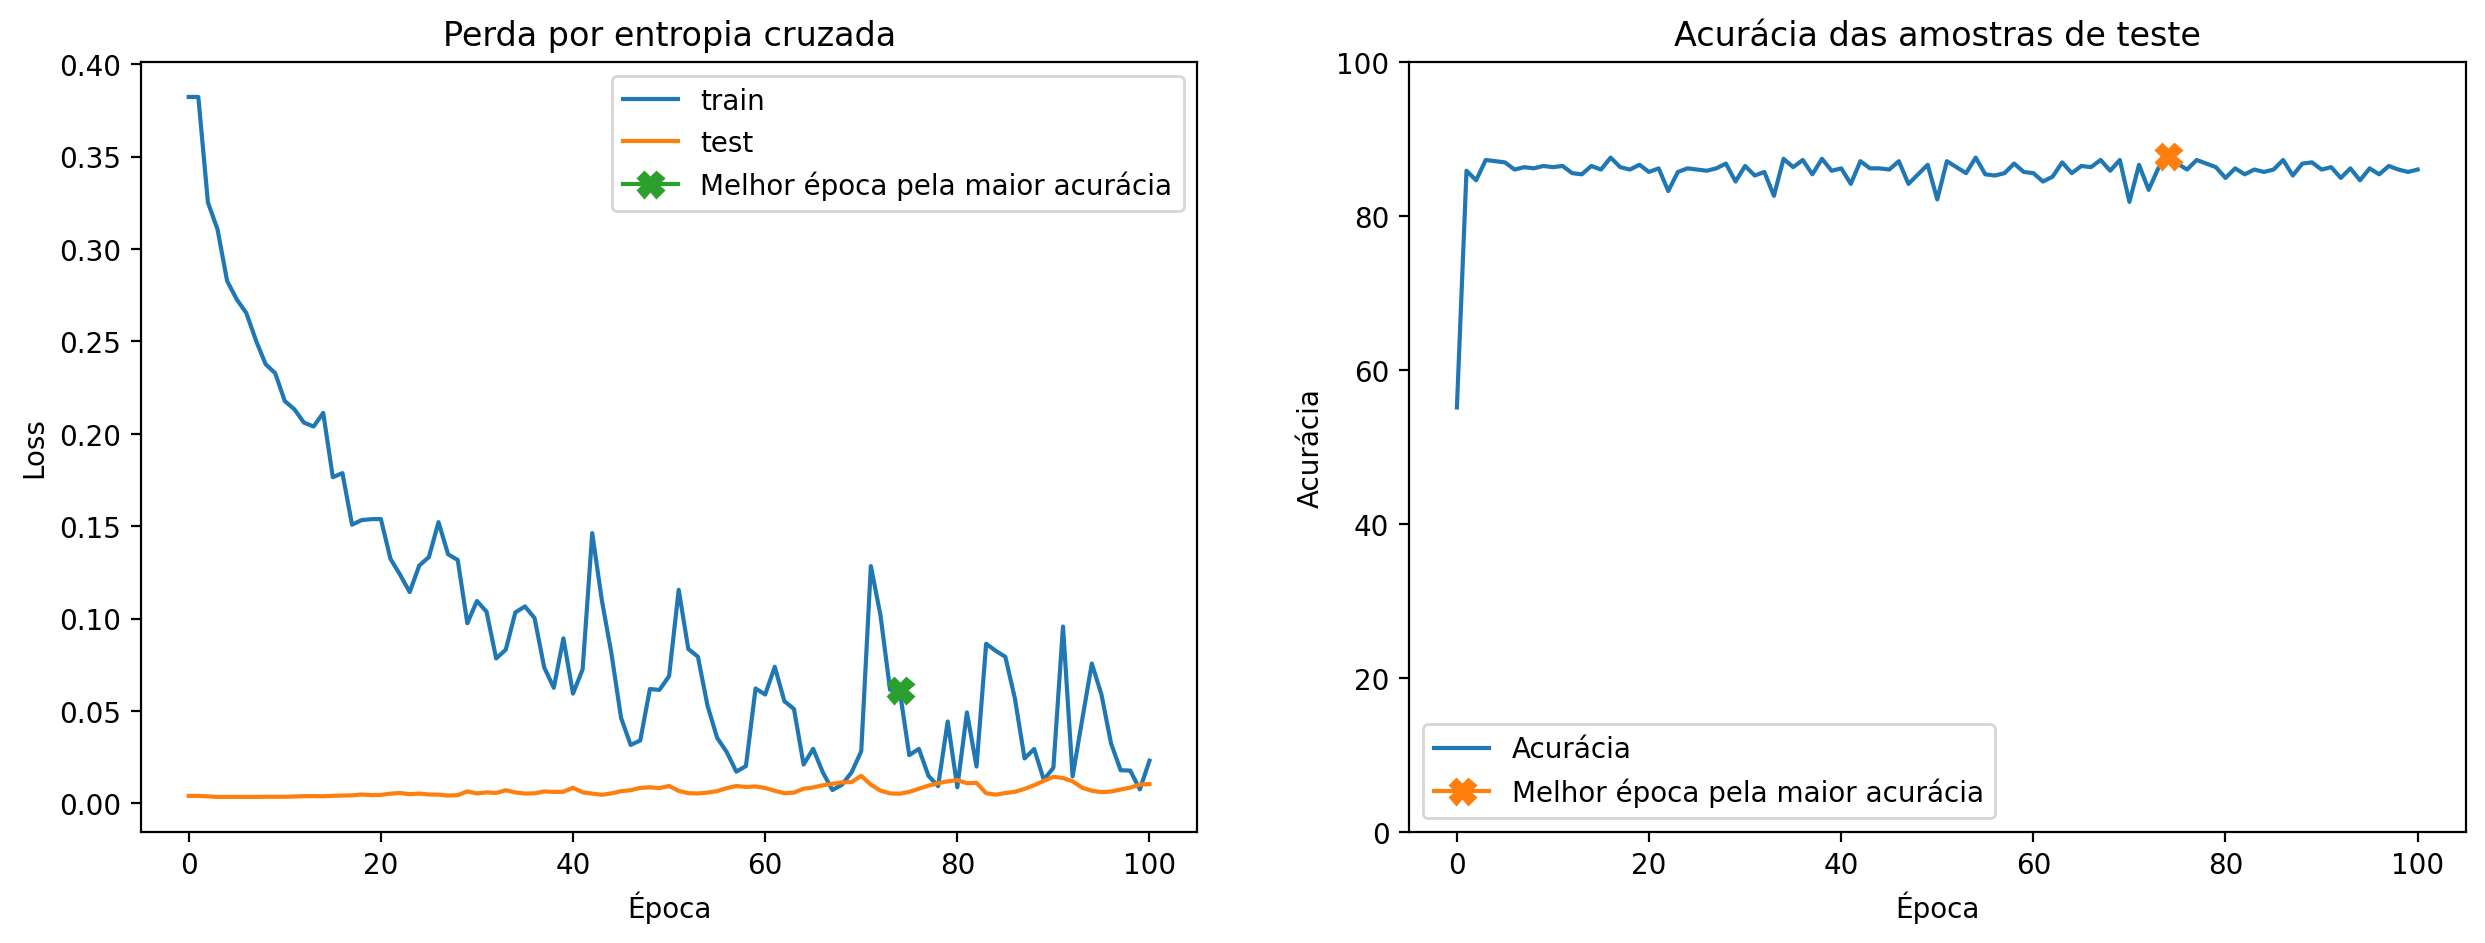

In [57]:
x_best = np.argmax(accs)
y_best = accs[x_best]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses_train, label='train')
ax[0].plot(losses_test, label='test')
ax[0].plot(x_best, losses_train[x_best], marker='X', ms=9, label='Melhor época pela maior acurácia')
ax[0].set_title('Perda por entropia cruzada')
ax[0].set_xlabel('Época')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(accs, label='Acurácia')
ax[1].plot(x_best, y_best, marker='X', ms=9, label='Melhor época pela maior acurácia')
ax[1].set_title('Acurácia das amostras de teste')
ax[1].set_xlabel('Época')
ax[1].set_ylabel('Acurácia')

plt.ylim(0, 100)
plt.legend()
plt.show()

## Avaliação do modelo considerando o melhor resultado

### Carregando os pesos do melhor cenário

In [48]:
best_weight = torch.load("pistachio_nn.pt")
best_weight # Imprimindo os pesos

<ipython-input-48-f73eb12c37a8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_weight = torch.load("pistachio_nn.pt")


OrderedDict([('fc.0.weight',
              tensor([[ 0.0686,  0.1603,  0.1746,  ..., -0.2109,  0.2406,  0.1567],
                      [-0.1537,  0.2179, -0.2268,  ..., -0.1018,  0.0330, -0.0055],
                      [-0.1085,  0.1990,  0.2067,  ..., -0.1418, -0.2210, -0.1682],
                      ...,
                      [-0.2287,  0.1741, -0.2103,  ..., -0.1575,  0.2478, -0.2074],
                      [ 0.1802,  0.1672, -0.1011,  ..., -0.1824,  0.2231, -0.1503],
                      [ 0.0214, -0.2177,  0.2222,  ..., -0.1324,  0.1745, -0.1419]])),
             ('fc.0.bias',
              tensor([ 0.1553, -0.1046,  0.0274, -0.1748,  0.2379, -0.0643, -0.1221,  0.2147,
                      -0.0414, -0.2349,  0.1430, -0.0381, -0.1334, -0.2218,  0.1178,  0.0698,
                       0.0408, -0.0436,  0.2275, -0.2178, -0.0918, -0.0655, -0.0233,  0.2337,
                       0.0281, -0.2271,  0.0018, -0.2469, -0.2792, -0.0104,  0.1873, -0.1125,
                      -0.0603,  0.

In [49]:
# Carregando no modelo
model.load_state_dict(best_weight)

<All keys matched successfully>

In [33]:
def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

### Acurácia do melhor cenário

In [66]:
y_pred = predict(model, dataset_train.dataset.x)
y = dataset_train.dataset.y.numpy()
accuracy = (y_pred == y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.952048417132216


### Matriz de confusão considerando o melhor cenário

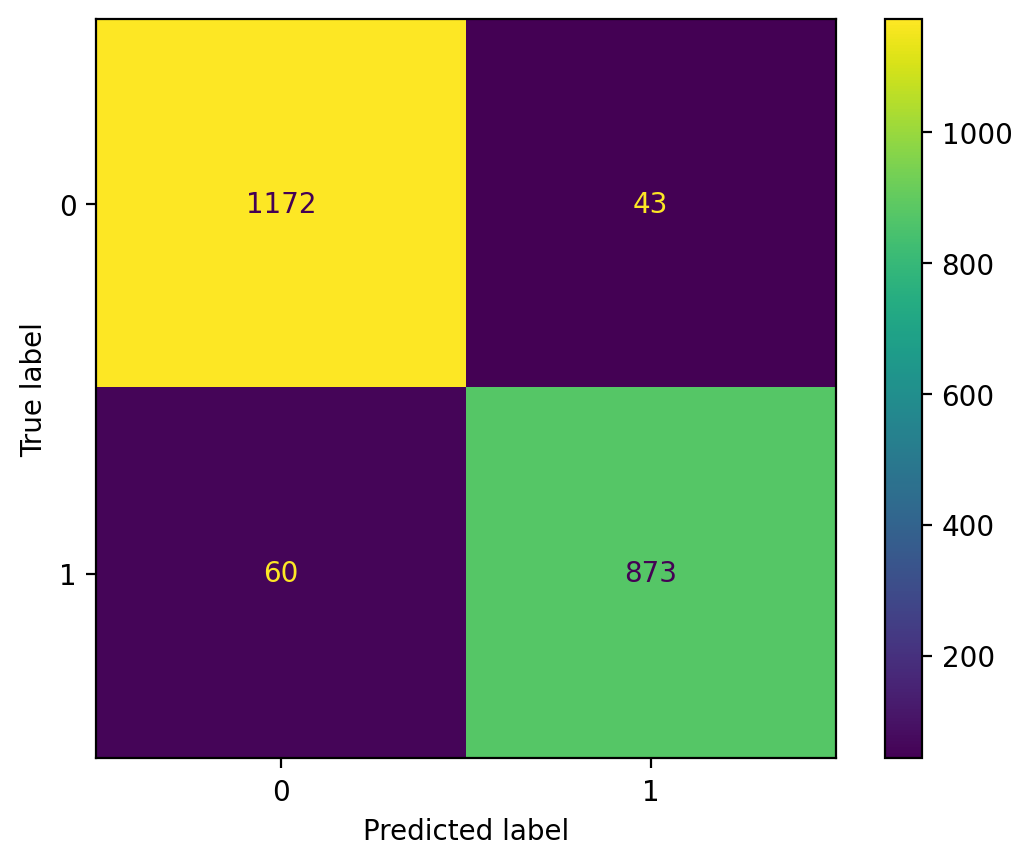

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_pred, y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

## Conclusão

O dataset escolhido é uma conjunto de amostras de pistache, que consiste em 12 features morfológicas e 4 de formato, totalizando 16 features. A versão expandida é composta por mais 12 features de coloração, totalizando 28. Para este projeto foi considerado o dataset reduzido,com 16 features. São amostras de dois tipos diferentes de sementes de pistache: Kirmizi_Pistachio e Siit_Pistachio.

Inicialmente, fez-se uma análise exploratória para identificar o tipo de dado a ser trabalhado, sendo em sua maioria do tipo ponto flutuante. Verificou-se que não há dados faltantes e amostras duplicadas, portanto nenhum tratamento foi necessário. Após a leitura do dataset e separação entre dado e classificação, realizou-se a normalização com Standard Scaler e a conversão da classe em códigos através do Label Encoder. Foram realizadas as transformações necessárias para que tanto os dados e o target se apresentassem no formato necessário para o treinamento da rede neural.

Após a criação o dataset com tensores, fez-se a separação entre treino e teste na proporção 70/30. Foram definidos o dataset e o data loader com batch size de 400 e 100 para treino e teste, respectivamente. A rede possui 16 entradas e duas saídas, correspondentes às 16 features e 2 classes de sementes. Criou-se uma rede linear utilizando o Sequential, com 7 camadas e função de ativação ReLU. As funções de treinamento e teste foram definidas e a avaliação é dada utilizando-se o otimizador Adam e critério pela perda por entropia cruzada. O melhor resultado foi salvo considerando o maior valor da acurácia.

O treinamento e avaliação foram realizados em 100 épocas e o resultado da perda e da acurácia obtidas em cada época foi apresentado no gráfico de linhas. Observa-se que a melhor acurácia foi obtida em uma época onde a perda não foi mínima. Também é possível verificar pelo gráfico que o modelo não sofreu overfitting, pois a perda de treino se manteve sempre superior à de teste.

Por fim, importou-se os pesos do melhor cenário para revalidação a acurácia e para geração da matriz de confusão do dataset de treino.

Percebe-se que o modelo foi capaz de apresentar resultados satisfatórios, com boa taxa de assertividade e perda baixa.